# Recommender library competition 
## By Amélie Madrona & Linne Verhoeven
Link to the [kaggle competition](https://www.kaggle.com/competitions/library-recommender-competition/overview)

Goal:
* Train recommender system on training interactions data
* Generate recommendations for each user ID in the dataset. 
* Provide the top 10 recommendations of your model for each user
* Make sure that your submission file has the same format as the sample_submission.csv file in the Data tab (i.e. separated by a space)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from bertopic import BERTopic
import seaborn as sns

In [33]:
interactions = pd.read_csv('data/interactions_train.csv')
print(interactions.shape)
interactions['t'] = pd.to_datetime(interactions['t'], unit='s')
interactions.head()

(87047, 3)


,u,i,t
0,4456,8581,2023-06-23 17:24:46
1,142,1964,2023-03-23 15:30:06
2,362,3705,2024-02-02 11:00:59
3,1809,11317,2023-01-12 14:19:22
4,4384,1323,2023-04-13 16:09:22


In [5]:
items = pd.read_csv('data/items.csv')
print(items.shape)
items.head()

(15291, 6)


,Title,Author,ISBN Valid,Publisher,Subjects,i
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4


In [6]:
sample_submission = pd.read_csv('data/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()


(7838, 2)


,user_id,recommendation
0,0,3758 11248 9088 9895 5101 6074 9295 14050 1096...
1,1,3263 726 1589 14911 6432 10897 6484 7961 8249 ...
2,2,13508 9848 12244 2742 11120 2893 2461 5439 116...
3,3,2821 10734 6357 5934 2085 12608 12539 10551 10...
4,4,12425 219 11602 1487 14178 489 13888 2110 4413...


In [7]:
n_users = interactions.u.nunique()
n_items = interactions.i.nunique()
print(f'Number of users = {n_users}, \nNumber of movies = {n_items} \nNumber of interactions = {len(interactions)}')
# So the sample submission is the top x items for each user
# And we have info for all the books in items

Number of users = 7838, 
Number of movies = 15109 
Number of interactions = 87047


In [8]:
# TODO: EDA on the interactions data and the items metadata. 

In [ ]:
# Basic
items = pd.read_csv('data/items.csv')
# Google enhanced first
google_enhanced_first = pd.read_csv('google_api_enhanced/all_items_enhanced.csv')
# ISBN enhanced:
isbn_enhanced = pd.read_csv('enhancing/items_enhanced_final.csv')
# Other way around:
# ISBN enhanced
isbn_enhanced_first = pd.read_csv('enhancing/isbndb_only.csv')
# Google enhanced
google_enhanced = pd.read_csv('enhancing/items_enhanced_final_isbnpriority.csv')

def get_clean_author(author_series):
    def clean_author_string(author):
        if pd.isna(author):
            return None
        # Remove all digits and dashes
        cleaned = re.sub(r'[\d\-]', '', author)
        # Collapse multiple spaces and strip
        cleaned = re.sub(r'\s+', ' ', cleaned).strip()
        return cleaned if cleaned else None

    clean_author = author_series.apply(clean_author_string)
    return clean_author
items['title_clean'] = items['Title'].apply(lambda x: x.rstrip(' /') if isinstance(x, str) else np.nan)
items['author_clean'] = get_clean_author(items['Author'])
def extract_isbn(text):
    if isinstance(text, str):
        for val in re.split(r'[;,]', text):
            cleaned = val.strip().replace('-', '')
            if cleaned.isdigit() and len(cleaned) in (10, 13):
                return cleaned
    return None
items['ISBN'] = items['ISBN Valid'].apply(extract_isbn)

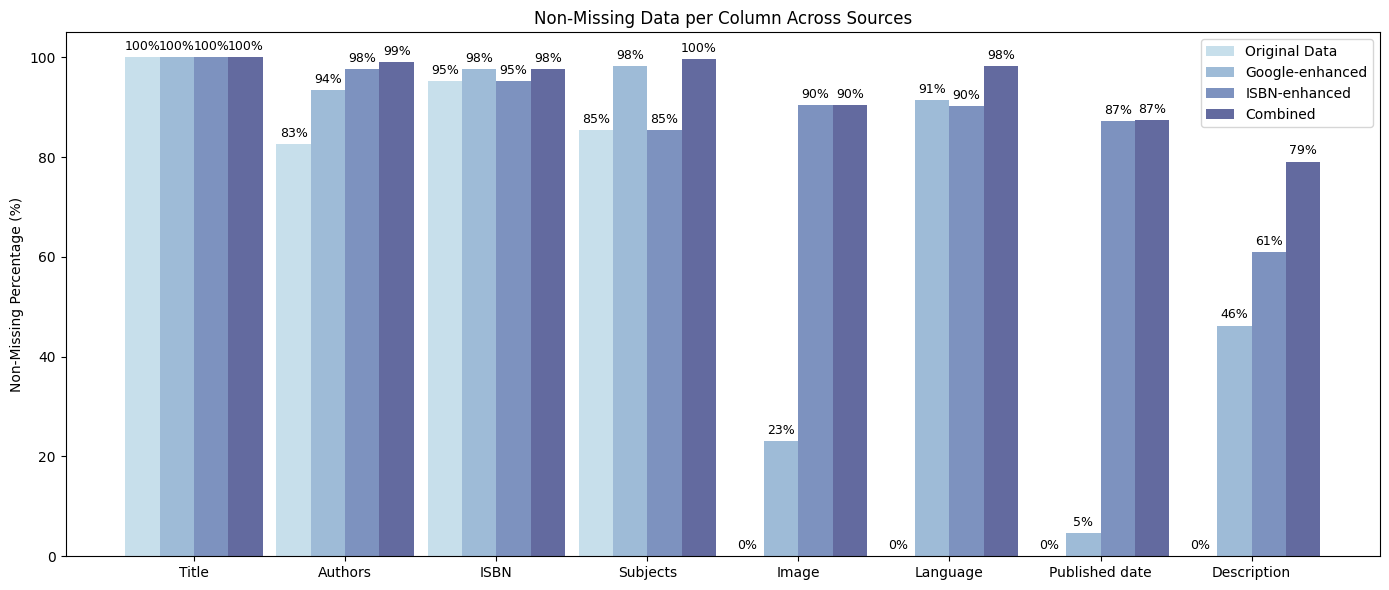

In [10]:
# Updated column names (renamed for clarity)
columns_of_interest = [
    'Image', 'Language', 'Published date', 'Subjects',
    'Authors', 'Title', 'Description', 'ISBN'
]


# Mapping for renaming columns
rename_mapping = {
    'PublishedDate': 'Published date',
    'author_clean': 'Authors',
    'title_clean': 'Title',
    'image': 'Image'
}

# Normalize 'ImageLink' to 'image'
def normalize_columns(df):
    df = df.copy()
    if 'ImageLink' in df.columns:
        df = df.rename(columns={'ImageLink': 'Image'})
    df = df.rename(columns=rename_mapping)
    # Remove duplicate columns, keeping the first occurrence
    df = df.loc[:, ~df.columns.duplicated()]
    return df

# Normalize and subset safely
def safe_subset(df, columns):
    return df[[col for col in columns if col in df.columns]]

df_items = safe_subset(normalize_columns(items), columns_of_interest)
df_google = safe_subset(normalize_columns(google_enhanced_first), columns_of_interest)
df_isbn = safe_subset(normalize_columns(isbn_enhanced_first), columns_of_interest)
df_combined = safe_subset(normalize_columns(isbn_enhanced.drop('ImageLink',axis = 1)), columns_of_interest)

# Get all columns present for consistent plotting
all_cols = [col for col in columns_of_interest if col in df_items.columns or col in df_google.columns or col in df_isbn.columns or col in df_combined.columns]

priority_cols = ['Title', 'Authors', 'ISBN', 'Subjects']
remaining_cols = [col for col in all_cols if col not in priority_cols]
all_cols = priority_cols + remaining_cols

# Function to compute non-missing percentages
def get_non_missing_percentage(df):
    pct = df.notnull().sum() / len(df) * 100
    return pct.reindex(all_cols, fill_value=0)

pct_items = get_non_missing_percentage(df_items)
pct_google = get_non_missing_percentage(df_google)
pct_isbn = get_non_missing_percentage(df_isbn)
pct_combined = get_non_missing_percentage(df_combined)

# Plotting
x = np.arange(0, len(all_cols) * 1.1, 1.1)
width = 0.25

# Use Seaborn color palette for better aesthetics
palette = sns.color_palette("ch:s=.25,rot=-.25")  # Or try "deep", "muted", etc.

fig, ax = plt.subplots(figsize=(14, 6))

bars1 = ax.bar(x - width, pct_items, width, label='Original Data', color=palette[0])
bars2 = ax.bar(x, pct_google, width, label='Google-enhanced', color=palette[1])
bars3 = ax.bar(x + width, pct_isbn, width, label='ISBN-enhanced', color=palette[2])
bars4 = ax.bar(x + 2 * width, pct_combined, width, label='Combined', color=palette[3])

ax.set_ylabel('Non-Missing Percentage (%)')
ax.set_title('Non-Missing Data per Column Across Sources')
ax.set_xticks(x + width * 0.5)  # shift to center of group
ax.set_xticklabels(all_cols)
ax.set_ylim(0, 105)
ax.legend()

# Annotate bars
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(round(height))}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("readme_images/non_missing_data_plot.png", bbox_inches='tight')
plt.show()

In [28]:
items

,Title,Author,ISBN Valid,Publisher,Subjects,i,title_clean,author_clean,ISBN
0,Classification décimale universelle : édition ...,NaN,9782871303336; 2871303339,Ed du CEFAL,Classification décimale universelle; Indexatio...,0,Classification décimale universelle : édition ...,None,9782871303336
1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine, 1947-",9782278058327; 2278058320,Didier,didactique--langue étrangère - enseignement; d...,1,Les interactions dans l'enseignement des langu...,"Cicurel, Francine,",9782278058327
2,Histoire de vie et recherche biographique : pe...,NaN,2343190194; 9782343190198,L'Harmattan,Histoires de vie en sociologie; Sciences socia...,2,Histoire de vie et recherche biographique : pe...,None,2343190194
3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain, 1980-",9782365350020; 236535002X; 9782365350488; 2365...,Vraoum!,Moyen-Orient; Bandes dessinées autobiographiqu...,3,Ce livre devrait me permettre de résoudre le c...,"Mazas, Sylvain,",9782365350020
4,Les années glorieuses : roman /,"Lemaitre, Pierre, 1951-",9782702180815; 2702180817; 9782702183618; 2702...,Calmann-Lévy,France--1945-1975; Roman historique; Roman fra...,4,Les années glorieuses : roman,"Lemaitre, Pierre,",9782702180815
...,...,...,...,...,...,...,...,...,...
15286,Le vagabond de Tokyo /,"Fukutani, Takashi, 1952-2000",9782353480111; 235348011X; 9782353480241; 2353...,Le Lézard noir,Mangas,15286,Le vagabond de Tokyo,"Fukutani, Takashi,",9782353480111
15287,God of high school : le match contre les dieux /,"Park, Yong-Je",9782382880203; 2382880201; 9782382880210; 2382...,Kbooks,NaN,15287,God of high school : le match contre les dieux,"Park, YongJe",9782382880203
15288,Blue Lock /,"Kaneshiro, Muneyuki",9782811650254; 2811650253; 9782811661274; 2811...,Pika,Compétitions; Football; Entraînement (sports);...,15288,Blue Lock,"Kaneshiro, Muneyuki",9782811650254
15289,Red eyes sword : akame ga kill ! Zero /,Takahiro,9782368522134; 2368522131; 9782368522141; 2368...,Kurokawa,Bandes dessinées; Mangas,15289,Red eyes sword : akame ga kill ! Zero,Takahiro,9782368522134


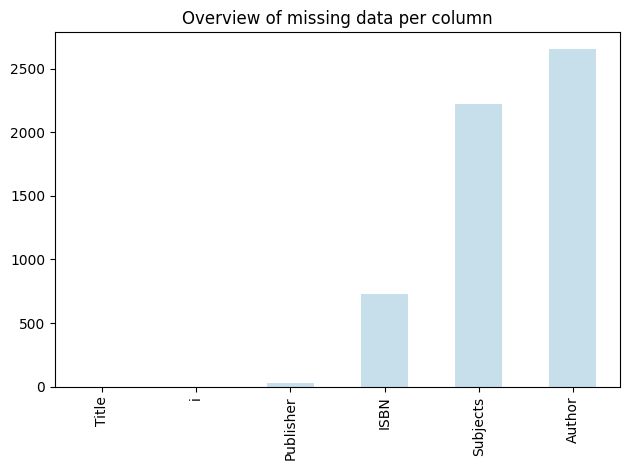

In [47]:
# Suppose your DataFrame is called df
missing_counts = items.drop(columns=['title_clean','author_clean','ISBN Valid'],axis = 1).isnull().sum().sort_values()  # count missing values per column

# Plot
missing_counts.plot(kind='bar', title="Overview of missing data per column", color=palette[0])
plt.tight_layout()
plt.savefig("readme_images/overview_missing_data.png")

plt.show()

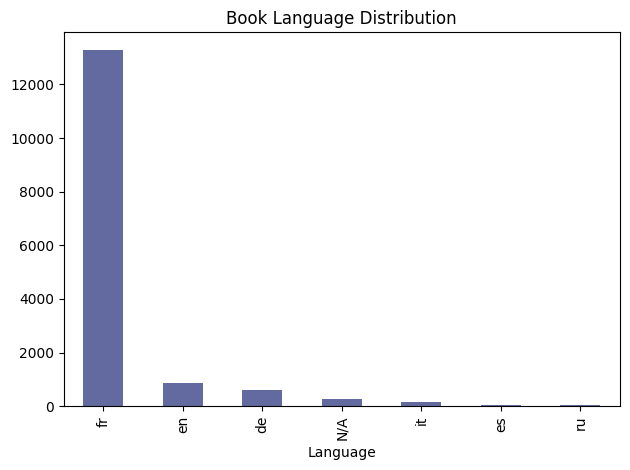

In [42]:
# Language Distribution
palette = sns.color_palette("ch:s=.25,rot=-.25")
ax = isbn_enhanced['Language'].fillna('N/A').value_counts()[:7].plot(kind='bar', title="Book Language Distribution", color=palette[3])
plt.tight_layout()
plt.savefig("readme_images/book_language_distribution.png")
plt.show()

Median number of interactions per user: 6.0
Mean number of interactions per user: 11.105766777239092
Max number of interactions per user: 385


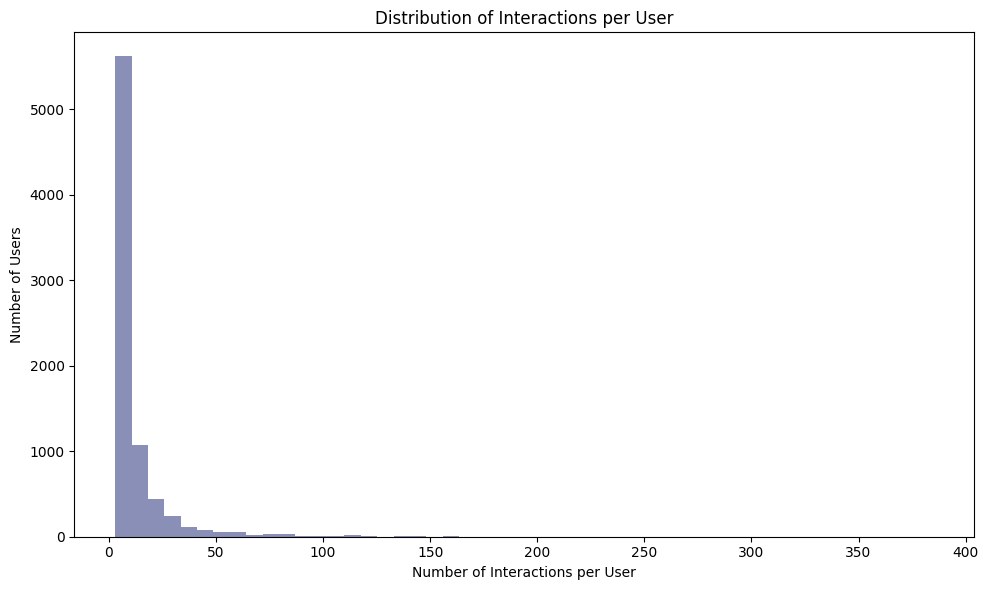

In [46]:
# Plot the distribution of number of interactions per user
user_interaction_counts = interactions['u'].value_counts()
# Calculate and print the median number of interactions per user
median_interactions = interactions['u'].value_counts().median()
print(f"Median number of interactions per user: {median_interactions}")
print(f"Mean number of interactions per user: {user_interaction_counts.mean()}")
print(f"Max number of interactions per user: {user_interaction_counts.max()}")

plt.figure(figsize=(10, 6))
sns.histplot(user_interaction_counts, bins=50, kde=False, color=palette[3], edgecolor=None)
plt.xlabel('Number of Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')
plt.tight_layout()
plt.savefig("readme_images/distribution_interactions_per_user.png")
plt.show()